In [36]:
import stackstac
import pystac_client
import rioxarray
import xarray as xr
import pyproj
import odc.geo.xr

In [2]:
iocg = rioxarray.open_rasterio(r'F:\LandfolioProspectivity\HLExtract\HAV_HAVILAH-RESOURCES_SOUTH-AUST_COPPER-_Kalkaroo_33336\HAV_HAVILAH-RESOURCES_SOUTH-AUST_COPPER-_Kalkaroo_33336_Exploracorn_Latest-IOCG-meanpComm.tif')

In [5]:
bb = iocg.rio.bounds()
centroid = ((bb[0] + bb[2])/2, (bb[1] + bb[3])/2)
centroid

(140.52408099076075, -31.73234950631702)

In [6]:
URL = "https://earth-search.aws.element84.com/v0"
catalog = pystac_client.Client.open(URL)

In [7]:
%%time
items = catalog.search(
    intersects=dict(type="Point", coordinates=[centroid[0], centroid[1]]),
    collections=["sentinel-s2-l2a-cogs"],
    datetime="2022-06-01/2022-06-16"
).get_all_items()
len(items)

CPU times: total: 0 ns
Wall time: 400 ms


3

In [8]:
%time stack = stackstac.stack(items)

CPU times: total: 15.6 ms
Wall time: 10 ms


In [9]:
stack

<xarray.DataArray 'stackstac-cbdf435183fda359a835cad041fc9195' (time: 3,
                                                                band: 17,
                                                                y: 10980,
                                                                x: 10980)>
dask.array<fetch_raster_window, shape=(3, 17, 10980, 10980), dtype=float64, chunksize=(1, 1, 1024, 1024), chunktype=numpy.ndarray>
Coordinates: (12/28)
  * time                          (time) datetime64[ns] 2022-06-05T00:45:58 ....
    id                            (time) <U24 'S2B_54HVK_20220605_1_L2A' ... ...
  * band                          (band) <U8 'overview' 'visual' ... 'WVP' 'SCL'
  * x                             (x) float64 4e+05 4e+05 ... 5.098e+05
  * y                             (y) float64 6.5e+06 6.5e+06 ... 6.39e+06
    sentinel:product_id           (time) <U60 'S2B_MSIL2A_20220605T003709_N04...
    ...                            ...
    sentinel:latitude_band        <U1 'H'
    title                         (band) <U31 'True color image' ... 'Scene C...
    common_name                   (band) object None None ... None None
    center_wavelength             (band) object None None 0.4439 ... None None
    full_width_half_max           (band) object None None 0.027 ... None None
    epsg                          int32 32754
Attributes:
    spec:        RasterSpec(epsg=32754, bounds=(399960.0, 6390220.0, 509760.0...
    crs:         epsg:32754
    transform:   | 10.00, 0.00, 399960.00|\n| 0.00,-10.00, 6500020.00|\n| 0.0...
    resolution:  10.0

In [11]:
rgb = stack.sel(band=["B04", "B03", "B02"])
rgb

C:\Users\rscott\AppData\Local\Continuum\anaconda3\envs\pvxarray2\lib\site-packages\dask\array\slicing.py:647: RuntimeWarning: overflow encountered in long_scalars
  maxsize = math.ceil(nbytes / (other_numel * itemsize))
C:\Users\rscott\AppData\Local\Continuum\anaconda3\envs\pvxarray2\lib\site-packages\xarray\core\indexing.py:1228: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  return self.array[key]


<xarray.DataArray 'stackstac-cbdf435183fda359a835cad041fc9195' (time: 3,
                                                                band: 3,
                                                                y: 10980,
                                                                x: 10980)>
dask.array<getitem, shape=(3, 3, 10980, 10980), dtype=float64, chunksize=(1, 1, 1024, 1024), chunktype=numpy.ndarray>
Coordinates: (12/28)
  * time                          (time) datetime64[ns] 2022-06-05T00:45:58 ....
    id                            (time) <U24 'S2B_54HVK_20220605_1_L2A' ... ...
  * band                          (band) <U8 'B04' 'B03' 'B02'
  * x                             (x) float64 4e+05 4e+05 ... 5.098e+05
  * y                             (y) float64 6.5e+06 6.5e+06 ... 6.39e+06
    sentinel:product_id           (time) <U60 'S2B_MSIL2A_20220605T003709_N04...
    ...                            ...
    sentinel:latitude_band        <U1 'H'
    title                         (band) <U31 'Band 4 (red)' ... 'Band 2 (blue)'
    common_name                   (band) object 'red' 'green' 'blue'
    center_wavelength             (band) object 0.6645 0.56 0.4966
    full_width_half_max           (band) object 0.038 0.045 0.098
    epsg                          int32 32754
Attributes:
    spec:        RasterSpec(epsg=32754, bounds=(399960.0, 6390220.0, 509760.0...
    crs:         epsg:32754
    transform:   | 10.00, 0.00, 399960.00|\n| 0.00,-10.00, 6500020.00|\n| 0.0...
    resolution:  10.0

In [18]:
x_utm, y_utm = pyproj.Proj(rgb.rio.crs)(centroid[0],centroid[1])
buffer = 10000  # meters

In [19]:
(x_utm,y_utm)

(454916.5785852597, 6489132.238502169)

In [20]:
aoi = rgb.loc[..., y_utm+buffer:y_utm-buffer, x_utm-buffer:x_utm+buffer]
aoi

<xarray.DataArray 'stackstac-cbdf435183fda359a835cad041fc9195' (time: 3,
                                                                band: 3,
                                                                y: 2000, x: 2000)>
dask.array<getitem, shape=(3, 3, 2000, 2000), dtype=float64, chunksize=(1, 1, 1024, 1024), chunktype=numpy.ndarray>
Coordinates: (12/28)
  * time                          (time) datetime64[ns] 2022-06-05T00:45:58 ....
    id                            (time) <U24 'S2B_54HVK_20220605_1_L2A' ... ...
  * band                          (band) <U8 'B04' 'B03' 'B02'
  * x                             (x) float64 4.449e+05 4.449e+05 ... 4.649e+05
  * y                             (y) float64 6.499e+06 6.499e+06 ... 6.479e+06
    sentinel:product_id           (time) <U60 'S2B_MSIL2A_20220605T003709_N04...
    ...                            ...
    sentinel:latitude_band        <U1 'H'
    title                         (band) <U31 'Band 4 (red)' ... 'Band 2 (blue)'
    common_name                   (band) object 'red' 'green' 'blue'
    center_wavelength             (band) object 0.6645 0.56 0.4966
    full_width_half_max           (band) object 0.038 0.045 0.098
    epsg                          int32 32754
Attributes:
    spec:        RasterSpec(epsg=32754, bounds=(399960.0, 6390220.0, 509760.0...
    crs:         epsg:32754
    transform:   | 10.00, 0.00, 399960.00|\n| 0.00,-10.00, 6500020.00|\n| 0.0...
    resolution:  10.0

In [21]:
import dask.diagnostics
with dask.diagnostics.ProgressBar():
    data = aoi.compute()

[########################################] | 100% Completed | 19.9s


In [22]:
data

<xarray.DataArray 'stackstac-cbdf435183fda359a835cad041fc9195' (time: 3,
                                                                band: 3,
                                                                y: 2000, x: 2000)>
array([[[[2820., 2746., 1721., ..., 1715., 1724., 1733.],
         [2474., 2756., 1932., ..., 1732., 1709., 1736.],
         [2050., 2437., 1974., ..., 1869., 1688., 1663.],
         ...,
         [2404., 2693., 2257., ..., 1732., 1604., 1436.],
         [2158., 2197., 1954., ..., 1793., 1600., 1416.],
         [2440., 2172., 1490., ..., 1836., 1838., 1612.]],

        [[1376., 1320.,  987., ...,  916.,  934.,  892.],
         [1262., 1350., 1036., ...,  962.,  985.,  920.],
         [1128., 1228., 1022., ..., 1012.,  927.,  913.],
         ...,
         [1214., 1462., 1200., ..., 1096., 1036.,  960.],
         [1228., 1266., 1158., ..., 1106., 1048.,  974.],
         [1454., 1226., 1048., ..., 1072., 1112., 1048.]],

        [[ 724.,  695.,  530., ...,  518.,  540.,  491.],
         [ 678.,  730.,  564., ...,  540.,  534.,  488.],
         [ 595.,  641.,  558., ...,  578.,  531.,  518.],
         ...,
...
         ...,
         [2222., 2527., 2041., ..., 1768., 1544., 1344.],
         [2110., 2159., 1867., ..., 1879., 1638., 1488.],
         [2370., 2049., 1416., ..., 1704., 1905., 1757.]],

        [[1350., 1348.,  971., ...,  932.,  912.,  930.],
         [1134., 1298., 1030., ..., 1000.,  922.,  901.],
         [ 996., 1128., 1040., ..., 1015.,  886.,  855.],
         ...,
         [1156., 1254., 1164., ..., 1088., 1014.,  944.],
         [1122., 1158., 1082., ..., 1092., 1011.,  996.],
         [1350., 1180.,  912., ..., 1070., 1154., 1100.]],

        [[ 684.,  674.,  530., ...,  488.,  484.,  505.],
         [ 630.,  696.,  558., ...,  513.,  505.,  514.],
         [ 624.,  633.,  516., ...,  552.,  520.,  457.],
         ...,
         [ 642.,  762.,  670., ...,  558.,  552.,  531.],
         [ 650.,  667.,  642., ...,  576.,  542.,  540.],
         [ 786.,  633.,  520., ...,  592.,  590.,  569.]]]])
Coordinates: (12/28)
  * time                          (time) datetime64[ns] 2022-06-05T00:45:58 ....
    id                            (time) <U24 'S2B_54HVK_20220605_1_L2A' ... ...
  * band                          (band) <U8 'B04' 'B03' 'B02'
  * x                             (x) float64 4.449e+05 4.449e+05 ... 4.649e+05
  * y                             (y) float64 6.499e+06 6.499e+06 ... 6.479e+06
    sentinel:product_id           (time) <U60 'S2B_MSIL2A_20220605T003709_N04...
    ...                            ...
    sentinel:latitude_band        <U1 'H'
    title                         (band) <U31 'Band 4 (red)' ... 'Band 2 (blue)'
    common_name                   (band) object 'red' 'green' 'blue'
    center_wavelength             (band) object 0.6645 0.56 0.4966
    full_width_half_max           (band) object 0.038 0.045 0.098
    epsg                          int32 32754
Attributes:
    spec:        RasterSpec(epsg=32754, bounds=(399960.0, 6390220.0, 509760.0...
    crs:         epsg:32754
    transform:   | 10.00, 0.00, 399960.00|\n| 0.00,-10.00, 6500020.00|\n| 0.0...
    resolution:  10.0

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


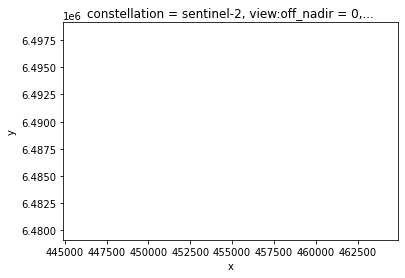

In [27]:
data.median(dim="time").squeeze().plot.imshow()

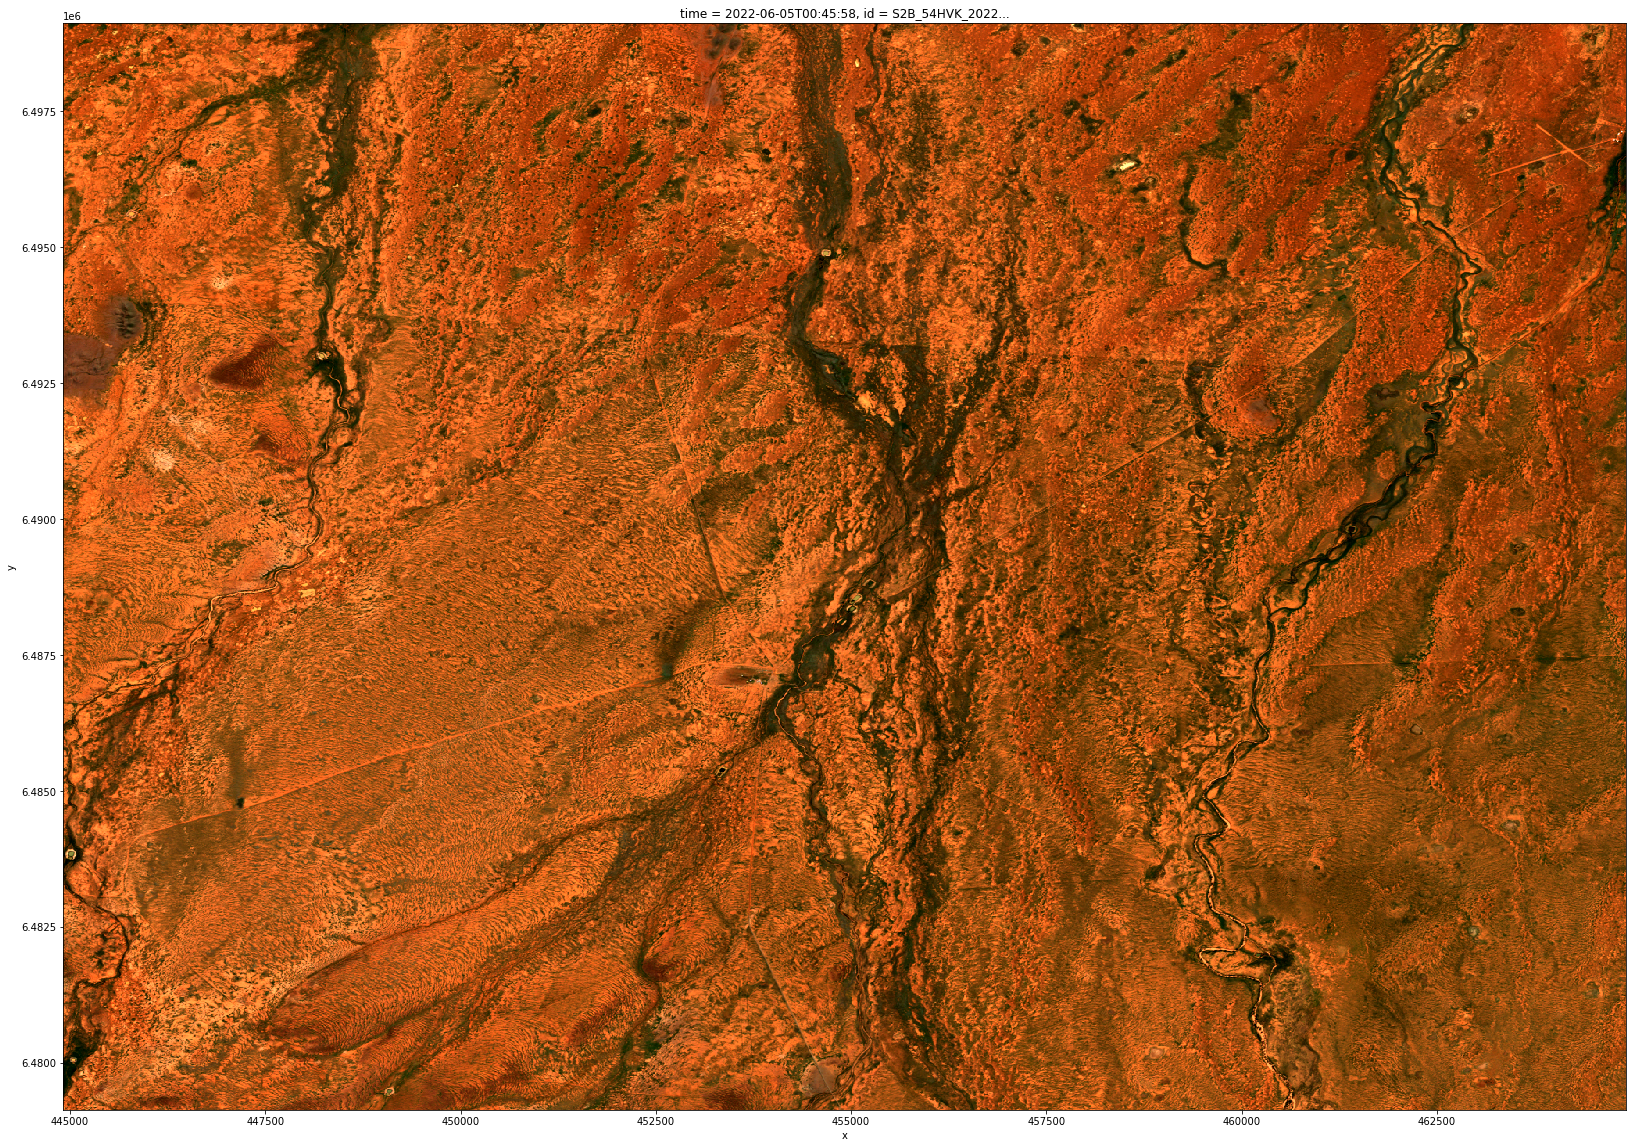

In [70]:
data.sel(time=['2022-06-05T00:45:58.000000000']).squeeze().plot.imshow(robust=True,figsize=(28,20))

In [44]:
vmin = data.quantile(0.02).values.item()
vmax = data.quantile(0.98).values.item()

In [45]:
vmin
vmax

4328.0

In [61]:
ds = data.to_dataset(dim="band")
ds

<xarray.Dataset>
Dimensions:                       (time: 3, y: 2000, x: 2000, band: 3)
Coordinates: (12/27)
  * time                          (time) datetime64[ns] 2022-06-05T00:45:58 ....
    id                            (time) <U24 'S2B_54HVK_20220605_1_L2A' ... ...
  * x                             (x) float64 4.449e+05 4.449e+05 ... 4.649e+05
  * y                             (y) float64 6.499e+06 6.499e+06 ... 6.479e+06
    sentinel:product_id           (time) <U60 'S2B_MSIL2A_20220605T003709_N04...
    constellation                 <U10 'sentinel-2'
    ...                            ...
    sentinel:latitude_band        <U1 'H'
    title                         (band) <U31 'Band 4 (red)' ... 'Band 2 (blue)'
    common_name                   (band) object 'red' 'green' 'blue'
    center_wavelength             (band) object 0.6645 0.56 0.4966
    full_width_half_max           (band) object 0.038 0.045 0.098
    epsg                          int32 32754
Dimensions without coordinates: band
Data variables:
    B04                           (time, y, x) float64 2.82e+03 ... 1.757e+03
    B03                           (time, y, x) float64 1.376e+03 ... 1.1e+03
    B02                           (time, y, x) float64 724.0 695.0 ... 569.0
Attributes:
    spec:        RasterSpec(epsg=32754, bounds=(399960.0, 6390220.0, 509760.0...
    crs:         epsg:32754
    transform:   | 10.00, 0.00, 399960.00|\n| 0.00,-10.00, 6500020.00|\n| 0.0...
    resolution:  10.0

In [62]:
ds.band

<xarray.DataArray 'band' (band: 3)>
array([0, 1, 2], dtype=int64)
Coordinates: (12/16)
    constellation                 <U10 'sentinel-2'
    view:off_nadir                int32 0
    sentinel:grid_square          <U2 'VK'
    sentinel:processing_baseline  <U5 '04.00'
    sentinel:boa_offset_applied   bool True
    instruments                   <U3 'msi'
    ...                            ...
    sentinel:latitude_band        <U1 'H'
    title                         (band) <U31 'Band 4 (red)' ... 'Band 2 (blue)'
    common_name                   (band) object 'red' 'green' 'blue'
    center_wavelength             (band) object 0.6645 0.56 0.4966
    full_width_half_max           (band) object 0.038 0.045 0.098
    epsg                          int32 32754
Dimensions without coordinates: band

In [63]:
#rgb = name="rgbato").odc.geo.xr.to_rgba(vmin,vmax)

rgb = odc.geo.xr.to_rgba(ds.median(dim="time"), bands=['B04', 'B03', 'B02'],vmin=vmin, vmax=vmax)

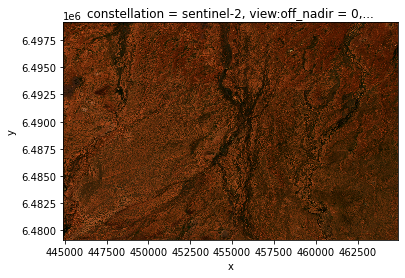

In [65]:
rgb.plot.imshow()

In [69]:
rgb.transpose('band', 'y', 'x').rio.write_crs('EPSG:32754').rio.to_raster(r'F:\Kalkaroo_Sentinel_False_Colour.tif')